In [1]:
import os
import torch
import numpy as np
from matplotlib import pyplot as plt

from model import ZeroTTT
from database import DataBase

In [2]:
# Hyperparams:
epochs = 1
lr = 3e-4
weight_decay = 1e-4

batch_size=400
'''
Remember that last index of 0th batch is 29
'''

'\nRemember that last index of 0th batch is 29\n'

In [3]:
database = DataBase()
db_path = "/storage/replay_buffer"
# model = ZeroTTT(brain_path="trained_model_3", opt_path="trained_opt_state_3", lr=lr, weight_decay=weight_decay, board_len=10)
model = ZeroTTT(brain_path=None, opt_path=None, lr=lr, weight_decay=weight_decay, board_len=10)

In [4]:
print(model.get_parameter_count())

183432


In [5]:
state_paths = [os.path.join(db_path, "states", name) for name in sorted(os.listdir("/storage/replay_buffer/states"))]
policy_paths = [os.path.join(db_path, "policy_labels", name) for name in sorted(os.listdir("/storage/replay_buffer/policy_labels"))]
value_paths = [os.path.join(db_path, "value_labels", name) for name in sorted(os.listdir("/storage/replay_buffer/value_labels"))]

names = list(zip(state_paths, policy_paths, value_paths))
filtered_names = []

for i in range(len(names)):
    index = int(names[i][0].split("_")[-1][:-4])
    if 126 < index < 1200:
        filtered_names.append(names[i])
names = filtered_names
test_set = names[-2:]
#names = names[:-2]
test_set = []

In [6]:
len(names)

0

In [7]:
def test_loss(model):
    model.brain.eval()
    total_p_loss = 0.0
    total_v_loss = 0.0
    for s, p, v in test_set:
        batch_sts, batch_pls, batch_vls = database.prepare_batches(batch_size=batch_size, from_memory_paths=(s, p, v))
        for b_nr in range(len(batch_sts)):
            batch_st, batch_pl, batch_vl = batch_sts[b_nr], batch_pls[b_nr], batch_vls[b_nr]
            
            batch_pl = torch.from_numpy(batch_pl).to(model.device)
            batch_vl = torch.from_numpy(batch_vl).float().to(model.device)
            prob, val = model.predict(batch_st, interpret_policy=False)
            val = val.flatten()

            p_loss = model.policy_loss(prob, batch_pl)
            v_loss = model.value_loss(val, batch_vl)
        
            total_p_loss += p_loss.item()
            total_v_loss += v_loss.item()
    return total_p_loss/(len(batch_sts)*len(test_set)), total_v_loss/(len(batch_sts)*len(test_set))

In [10]:
def train_model(model_name, model_opt_state, lr, weight_decay, epochs, batch_size, ind1, ind2, model_num, index):
    model = ZeroTTT(brain_path=model_name, opt_path=model_opt_state, lr=lr, weight_decay=weight_decay, board_len=10)
    
    train_policy_losses = []
    train_value_losses = []
    test_policy_losses = []
    test_value_losses = []
           
    db = DataBase(max_len=1000000)
    for num in range(ind1, ind2):
        db.load_data("/storage/supervised_data", num) 
                            
    for e in range(epochs):
        model.brain.train()
        
        batch_sts, batch_pls, batch_vls = db.prepare_batches(batch_size)
         
        for b_nr in range(len(batch_sts)):
            
            model.optimizer.zero_grad()
            batch_st, batch_pl, batch_vl = batch_sts[b_nr], batch_pls[b_nr], batch_vls[b_nr]
            
            batch_pl = torch.from_numpy(batch_pl).to(model.device)
            batch_vl = torch.from_numpy(batch_vl).float().to(model.device)
            prob, val = model.predict(batch_st, interpret_output=False)
            val = val.flatten()

            p_loss = model.policy_loss(prob, batch_pl)
            # p_loss /= 4.0
            v_loss = model.value_loss(val, batch_vl)

            train_policy_losses.append(p_loss.item())
            train_value_losses.append(v_loss.item())

            loss = p_loss + v_loss
            loss.backward()

            model.optimizer.step()
    
        # Loss on test set:
        # test_epoch_policy_loss, test_epoch_value_loss = test_loss(model)
        print(f"Epoch #{e} train policy loss: {sum(train_policy_losses)/len(train_policy_losses)} | train value loss: {sum(train_value_losses)/len(train_value_losses)}")
        # print(f"Test policy loss: {test_epoch_policy_loss} | Test value loss: {test_epoch_value_loss}")
        # test_policy_losses.append(test_epoch_policy_loss)
        # test_value_losses.append(test_epoch_value_loss)
        # Checkpoint:
        model.save_brain(f"trained_model_{model_num}_{index}", f"trained_opt_state_{model_num}_{index}")
                    
        plt.plot(train_policy_losses)
        # plt.plot(test_policy_losses)
        plt.show()
                    
        plt.plot(train_value_losses)
        # plt.plot(test_policy_losses)
        plt.show()

Epoch #0 train policy loss: 3.9533398037847807 | train value loss: 0.9947980207168251
Saving brain...


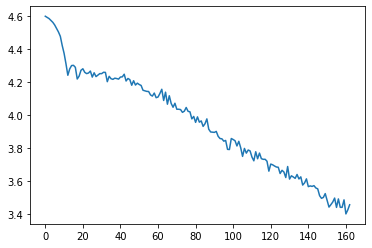

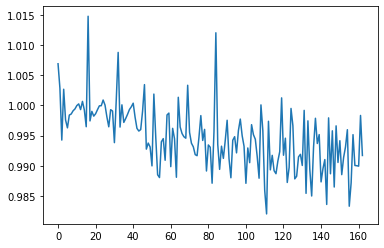

In [11]:
train_model(None, None, 3e-4, 1e-4, 1, 1500, 0, 1, 0, 0)